# Notebook 4: Fine-tuning a SpaceNet pre-trained model with `solaris`

This notebook is developed for the FOSS4G International 2019 `solaris` Workshop. If you're using it outside of that context, some of the working environment materials will be unavailable. Check the GitHub repo for instructions on how to alter the notebooks for usage outside of the workshop.
 
## Summary

This notebook shows how to take a pre-trained SpaceNet Challenge-winning model and fine-tune it to work on a new imagery dataset. Note that this task requires a fair amount of computational oomph, and will be very slow without access to a GPU.

This notebook is split into 3 parts:

1. [__Checking model performance on a new dataset__](#Checking-model-performance-on-a-new-dataset)

    1. [Calculating dataset mean and standard deviation](#Calculating-dataset-mean-and-standard-deviation)
    2. [Re-writing the YAML config file for a new experiment](#Re-writing-the-YAML-config-file-for-a-new-experiment)
    3. [Evaluating prediction quality on Khartoum data](#Evaluating-prediction-quality-on-Khartoum-data)


2. [__Fine-tuning the model__](#fine-tuning-the-model)

    1. [Creating training masks](#Creating-training-masks)
    2. [Building the config file](#Building-the-config-file)
    3. [Model training](#Model-training)


3. [__Scoring model performance after fine-tuning__](#scoring-model-performance-after-fine-tuning)

## Checking model performance on a new dataset

When a model is trained on imagery from one geography (or even a small set of geographies), it may not _"generalize"_ well, i.e. it may perform poorly on previously unseen geographies. Let's test that out with the [Khartoum AOI from the SpaceNet Dataset](https://spacenet.ai/spacenet-buildings-dataset-v2/).

### Calculating dataset mean and standard deviation
First, it's important to ensure that the data from Khartoum is normalized the same way as the data from Atlanta, as differences in intensity will propogate through the entire network, disrupting model performance. The Atlanta data is Z-scored, so we will do the same for Khartoum; to this end, we need to calculate the mean and standard deviation for each channel in the Khartoum dataset.

In [19]:
import solaris as sol
import numpy as np
import os

data_path = 'data'   # NON-WORKSHOP PARTICIPANTS: change this path to point to the directory where you've stored the data.

ims = [f for f in os.listdir(os.path.join(data_path, 'Khartoum_data/RGB_imagery'))]

R_cts = np.zeros(shape=(199,), dtype='uint32')
G_cts = np.zeros(shape=(199,), dtype='uint32')
B_cts = np.zeros(shape=(199,), dtype='uint32')
bins = np.arange(0, 2000, 10)

for idx, im in enumerate(ims):
    curr_im = sol.utils.io.imread(os.path.join(data_path, 'Khartoum_data', 'RGB_imagery', im))
    R_cts += np.array(np.histogram(curr_im[:, :, 0], bins=bins)[0], dtype='uint32')
    G_cts += np.array(np.histogram(curr_im[:, :, 1], bins=bins)[0], dtype='uint32')
    B_cts += np.array(np.histogram(curr_im[:, :, 2], bins=bins)[0], dtype='uint32')
    if idx%100 == 0:
        print("# {} of {} completed".format(idx, len(ims)))

# 0 of 1012 completed
# 100 of 1012 completed
# 200 of 1012 completed
# 300 of 1012 completed
# 400 of 1012 completed
# 500 of 1012 completed
# 600 of 1012 completed
# 700 of 1012 completed
# 800 of 1012 completed
# 900 of 1012 completed
# 1000 of 1012 completed


Let's look at the histogram of values for the channels. We're going to skip the first bin, as this is almost exclusively made up of `0` values. Zeros correspond to no data in these images.

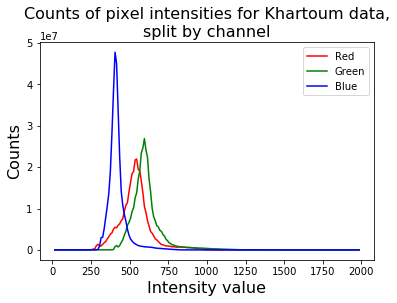

In [30]:
import matplotlib.pyplot as plt
f, ax = plt.subplots()
ax.plot(bins[1:-1] + 5, R_cts[1:], label='Red', color='red')
ax.plot(bins[1:-1] + 5, G_cts[1:], label='Green', color='green')
ax.plot(bins[1:-1] + 5, B_cts[1:], label='Blue', color='blue')
ax.legend(loc='upper right')
ax.set_xlabel('Intensity value', size=16)
ax.set_ylabel('Counts', size=16)
ax.set_title('Counts of pixel intensities for Khartoum data,\nsplit by channel',
             size=16);


In the next cell we'll calculate the mean and standard deviation to normalize these intensities.

In [36]:
def mean_and_std_from_histogram(bins, cts):
    """Calculate the mean and standard deviation from a histogram."""
    bin_centers = bins[1:-1] + ((bins[1]-bins[0])/2.)
    # skip the first bin since it contains the nodata values
    mean = np.sum(cts[1:]*bin_centers)/np.sum(cts[1:])
    std = np.sqrt((1./sum(cts[1:]))*np.sum(cts[1:]*np.square(bin_centers-mean)))
    return mean, std

r_mean, r_std = mean_and_std_from_histogram(bins, R_cts)
print("Red mean: {}".format(r_mean))
print("Red standard deviation: {}".format(r_std))
g_mean, g_std = mean_and_std_from_histogram(bins, G_cts)
print("Green mean: {}".format(g_mean))
print("Green standard deviation: {}".format(g_std))
b_mean, b_std = mean_and_std_from_histogram(bins, B_cts)
print("Blue mean: {}".format(b_mean))
print("Blue standard deviation: {}".format(b_std))

Red mean: 535.3377118832116
Red standard deviation: 102.57997193422042
Green mean: 606.4059096208762
Green standard deviation: 98.70072193970941
Blue mean: 417.72207177718127
Blue standard deviation: 58.06046284618483


Because the [`albumentations`](https://albumentations.readthedocs.io/en/latest/index.html) library used in `solaris`  divides pixel intensity by the bit depth before performing normalization, we need to divide these by 65535 (the unsigned 16-bit max) for use as parameters in the pipeline.

In [37]:
print("r_mean for config file: {}".format(r_mean/65535))
print("g_mean for config file: {}".format(g_mean/65535))
print("b_mean for config file: {}".format(b_mean/65535))
print("r_std for config file: {}".format(r_std/65535))
print("g_std for config file: {}".format(g_std/65535))
print("b_std for config file: {}".format(b_std/65535))

r_mean for config file: 0.008168729867753285
g_mean for config file: 0.00925316105319106
b_mean for config file: 0.006374030239981403
r_std for config file: 0.0015652700379067738
g_std for config file: 0.0015060764772977708
b_std for config file: 0.0008859458739022634


These values (to a few decimal places) should be used in the config file.

### Re-writing the YAML config file for a new experiment

There are three other changes that need to be made to the original config files:
1. Remove the `DropChannel` pre-processing step: unlike the Atlanta dataset, these image files only have three channels. We therefore don't need to drop a 4th channel.
2. `SwapChannels`: The MVOI Atlanta dataset is B-G-R channel order, but Khartoum is R-G-B. We therefore need to use the `SwapChannels` pre-processing step to switch the channels at index `0` and `2`. Because we're using PyTorch models, these channels will be at axis 1.
3. `inference_data_csv`: because we're fine-tuning on different training data, we'll need to point to a CSV specifying different data. That CSV, `khartoum_inf.csv`, can be found in the `workshop_configs` directory.

Feel free to try to create this yourself from a copy of the `xdxd_workshop_infer.yml` file. Alternatively, we've provided the file for you as `xdxd_workshop_khartoum_infer.yml`.

__Let's try it out!__

### Evaluating prediction quality on Khartoum data

We'll check to see how well the model trained on Atlanta data performs when we test on this image of Khartoum from the [SpaceNet 2: Building Footprint Extraction Challenge](https://spacenet.ai/spacenet-buildings-dataset-v2/):

<img src="files/khartoum_infer_for_viz.png">

In [1]:
import solaris as sol
import numpy as np
import os
import time
import skimage
from shapely.ops import cascaded_union  # just for visualization purposes

data_path = 'data'   # NON-WORKSHOP PARTICIPANTS: change this path to point to the directory where you've stored the data.

print('Loading config...')
config = sol.utils.config.parse(os.path.join(data_path, 'workshop_configs/xdxd_workshop_khartoum_infer.yml'))
print('config loaded. Initializing model...')
xdxd_inferer = sol.nets.infer.Inferer(config)
print('model initialized. Loading dataset...')
inf_df = sol.nets.infer.get_infer_df(config)
print('dataset loaded. Running inference on the image.')
start_time = time.time()
xdxd_inferer(inf_df)
end_time = time.time()
print('running inference on one image took {} seconds'.format(end_time-start_time))
# print('vectorizing output...')
# resulting_preds = skimage.io.imread(os.path.join('inference_out', 'MVOI_nadir10_test_sample.tif'))
# predicted_footprints = sol.vector.mask.mask_to_poly_geojson(
#     pred_arr=resulting_preds,
#     reference_im=os.path.join(data_path, MVOI_data, inf_df.loc[0, 'image']))
# print('output vectorized.')
# cascaded_union(predicted_footprints['geometry'].values)

Loading config...
config loaded. Initializing model...
model initialized. Loading dataset...
dataset loaded. Running inference on the image.


/anaconda3/envs/solaris/lib/python3.6/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


running inference on one image took 46.71587896347046 seconds


Text(0.5, 1.0, 'Ground Truth')

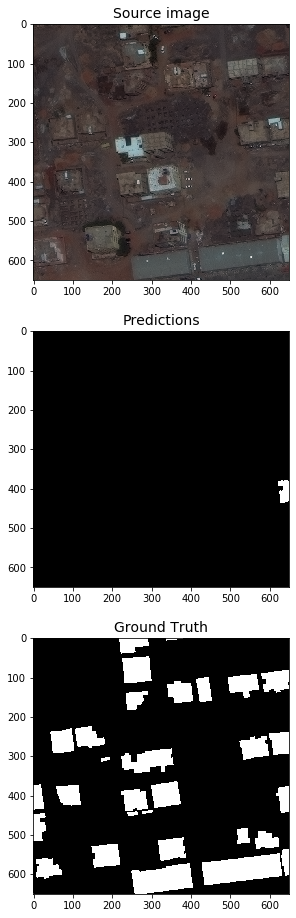

In [15]:
import numpy as np
import matplotlib.pyplot as plt

src_im_path = os.path.join(data_path, 'Khartoum_data/RGB_imagery/RGB-PanSharpen_AOI_5_Khartoum_img924.tif')
# read the image in
im_arr = skimage.io.imread(src_im_path)
# rescale to min/max in each channel
im_arr = im_arr.astype('float') - np.amin(im_arr, axis=(0,1))
im_arr = im_arr/np.amax(im_arr, axis=(0,1))
im_arr = (im_arr*255).astype('uint8')
# generate mask from the predictions
pred_arr = skimage.io.imread('xdxd_inference_out/RGB-PanSharpen_AOI_5_Khartoum_img924.tif')
preds = (pred_arr[:, :, 0] > 0).astype('uint8')
ground_truth = sol.vector.mask.footprint_mask(
    os.path.join(data_path, 'Khartoum_data/geojson/buildings_AOI_5_Khartoum_img924.geojson'),
    reference_im=src_im_path)

f, axarr = plt.subplots(3, 1, figsize=(8,16))
axarr[0].imshow(im_arr)
axarr[0].set_title('Source image', size=14)
axarr[1].imshow(preds, cmap='gray')
axarr[1].set_title('Predictions', size=14)
axarr[2].imshow(ground_truth, cmap='gray')
axarr[2].set_title('Ground Truth', size=14)

These predictions are clearly terrible - the model is only finding one of the buildings in this image. However, if we directly examine the prediction outputs, we'll see that we're not _too_ far from a good model - it's finding some buildings, just at such a low raw confidence value that it can't distinguish them from background. Remember that the model takes anything with a raw prediction > 0 as a building.

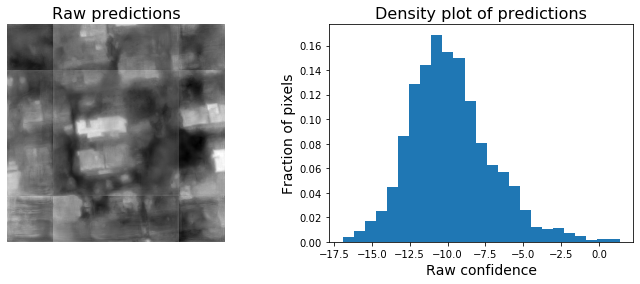

In [20]:
f, axarr = plt.subplots(1, 2, figsize=(12,4))
axarr[0].imshow(pred_arr[:, :, 0], cmap='gray')
axarr[0].axis('off')
axarr[0].set_title('Raw predictions', size=16)
axarr[1].hist(pred_arr.flatten(), bins=25, density=True)
axarr[1].set_xlabel('Raw confidence', size=14)
axarr[1].set_ylabel('Fraction of pixels', size=14)
axarr[1].set_title('Density plot of predictions', size=16);

So, what can we do to improve model performance? Let's try fine-tuning!

## Fine-tuning the model

### Creating training masks
Before we can continue training a model, we need target masks: images that the model will learn to create during training. We'll follow [this tutorial](https://solaris.readthedocs.io/en/latest/tutorials/notebooks/api_masks_tutorial.html) to create masks:

In [24]:
mask_dir = os.path.join(data_path, 'Khartoum_data', 'training_masks')
geojson_dir = os.path.join(data_path, 'Khartoum_data', 'geojson')
im_dir = os.path.join(data_path, 'Khartoum_data', 'RGB_imagery')
geojson_list = [f for f in os.listdir(geojson_dir) if f.endswith('.geojson')]
im_list = [f for f in os.listdir(geojson_dir) if f.endswith('.tif')]
n_chips = len(geojson_list)

if not os.path.exists(mask_dir):
    os.mkdir(mask_dir)
    
    for idx, gj in enumerate(geojson_list):
        # get the 'img[number] chip ID for the image'
        chip_id = os.path.splitext(gj)[0].split('_')[-1]
        matching_im = 'RGB-PanSharpen_AOI_5_Khartoum_' + chip_id + '.tif'
        mask_fname = 'mask_' + chip_id + '.tif'
        fp_mask = sol.vector.mask.footprint_mask(df=os.path.join(geojson_dir, gj),
                                                 out_file=os.path.join(mask_dir, mask_fname),
                                                 reference_im=os.path.join(im_dir, matching_im),
                                                 shape=(650, 650))
        if (idx+1)%100 == 0:
            print('chip {} of {} done'.format(idx+1, n_chips), flush=True)

chip 100 of 1012 done
chip 200 of 1012 done
chip 300 of 1012 done
chip 400 of 1012 done
chip 500 of 1012 done
chip 600 of 1012 done
chip 700 of 1012 done
chip 800 of 1012 done
chip 900 of 1012 done
chip 1000 of 1012 done


Let's look at one of these just to make sure they came out right:

(-0.5, 649.5, 649.5, -0.5)

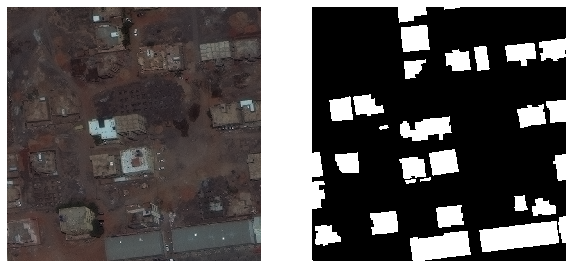

In [28]:
f, axarr = plt.subplots(1, 2, figsize=(10, 6))
axarr[0].imshow(skimage.io.imread('files/khartoum_infer_for_viz.tif'))
axarr[0].axis('off')
axarr[1].imshow(skimage.io.imread(os.path.join(data_path, 'Khartoum_data', 'training_masks', 'mask_img924.tif')),
                cmap='gray')
axarr[1].axis('off')

Looks good! We're ready to set up for training.

### Building the config file

With model fine-tuning, we'll load the pre-trained weights used above, and continue training at a much lower learning rate for a couple of epochs. To this end we'll need _another_ config with a few more modifications:

1. A reduced learning rate - we'll try `1e-5` instead of `1e-4`
2. Change `train=False` to `train=True`
3. Specify where the newly trained versions are saved with the `training['callbacks']['model_checkpoint']` arguments
4. Specify a training data CSV. In this case, we'll use a CSV created [per this tutorial](https://solaris.readthedocs.io/en/latest/tutorials/notebooks/creating_im_reference_csvs.html) that points to all of the images and the masks that we just created, save for one: the image that we inferenced against earlier, which we'll save as a test image. The csv, named `khartoum_fine_tune.csv`, is available in the `workshop_configs` directory.

As earlier, feel free to create this config yourself; otherwise, you can use `xdxd_workshop_khartoum_train.yml`.

### Model training

Let's try it!

In [35]:
print('Loading config...')
config = sol.utils.config.parse(os.path.join(data_path, 'workshop_configs/xdxd_workshop_khartoum_train.yml'))
print('config loaded. Initializing Trainer instance...')
xdxd_trainer = sol.nets.train.Trainer(config)
print('model initialized. Beginning training...')
print()
start_time = time.time()
xdxd_trainer.train()
end_time = time.time()
print()
print('training took {} minutes'.format((end_time-start_time)/60))


Loading config...
config loaded. Initializing Trainer instance...
model initialized. Beginning training...

Beginning training epoch 0


AssertionError: Torch not compiled with CUDA enabled